In [50]:
%load_ext autoreload

%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
from plot_images import plot_images
from tools import load_json, read_yaml_config, export_annos, final_join, filter_by_csv, assign_viewpoints, apply_filters
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Load data

In [52]:
config_file_path = 'configs/config.yaml'
species = 'giraffe'
config = read_yaml_config(config_file_path, species)
print(config)

anno_path = config["preprocessed_annotation_path"]

images_dir = config["images_dir"]

excluded_viewpoints = config['excluded_viewpoints']

data = load_json(anno_path)


dfa = pd.DataFrame(data['annotations'])
dfi = pd.DataFrame(data['images'])
dfn = pd.DataFrame(data['individuals'])
dfc = pd.DataFrame(data['categories'])

# dfi = dfi.drop_duplicates(keep='first')

assert not dfi.astype(str).duplicated().any()

df = dfa.merge(dfi, left_on='image_uuid', right_on='uuid')
df = df.merge(dfn, left_on='individual_uuid', right_on='uuid')
df = df.merge(dfc, left_on='category_id', right_on='id')

assert not df.astype(str).duplicated().any()

counts = df.groupby('viewpoint').size()
print(counts)


df['path'] = df['file_name'].apply(lambda x: os.path.join(images_dir, x))

assert df['path'].apply(os.path.exists).all()

{'data_dir': '/media/kate/Elements1/ISYNC-LUT/giraffe_TAMIL/giraffe_eda1/coco', 'export_dir': '/media/kate/Elements1/ISYNC-LUT/giraffe_TAMIL/giraffe_eda1/coco/split', 'images_dir': '/media/kate/Elements1/ISYNC-LUT/giraffe_TAMIL/giraffe_eda1/coco/images/test2023', 'raw_annotation_path': '/media/kate/Elements1/ISYNC-LUT/giraffe_TAMIL/giraffe_eda1/coco/annotations/instances_train2023.json', 'preprocessed_annotation_path': '/media/kate/Elements1/ISYNC-LUT/giraffe_TAMIL/giraffe_eda1/coco/annotations/preprocessed.json', 'excluded_viewpoints': [], 'csv_dir': '/media/kate/Elements1/ISYNC-LUT/giraffe_TAMIL/giraffe_eda1/coco/csvs', 'csv_column_names': ['annotation_uuid', 'species', 'viewpoint', 'name_uuid', 'name', 'date'], 'merge_cols': ['annotation_uuid', 'viewpoint_y']}
viewpoint
front       7
left     1433
right    1429
dtype: int64


In [53]:
df['name_viewpoint'] = df['name'] + '-' + df['viewpoint']
df['species_viewpoint'] = df['species'] + '-' + df['viewpoint']

In [54]:
# Remove singletons
df = apply_filters(df, 'name_viewpoint', None, min_df=2)

print("Annotations after removing singletons:", len(df))

# Remove annotations without name
df = df[df['name'] != '____']
df = df.reset_index(drop=True)

print("Annotations after removing annotations without name:", len(df))

counts = df.groupby('viewpoint').size()
print(counts)

Annotations after removing singletons: 2857
Annotations after removing annotations without name: 2857
viewpoint
front       7
left     1427
right    1423
dtype: int64


2857
532


<AxesSubplot:>

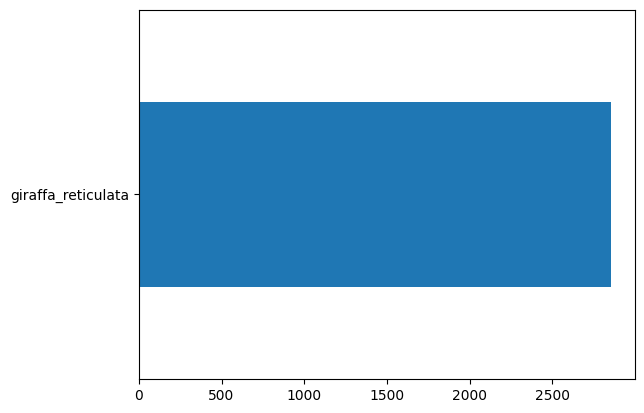

In [55]:
print(len(df))

print(len(df['name_viewpoint'].unique()))

df['species'].value_counts().plot(kind='barh')


In [56]:
# Make sure merging did not create duplicates
assert not df.astype(str).duplicated().any()

### Split
- The split 

In [57]:
from split import split_df

In [58]:
print(df['species'].value_counts())
print(len(df['name_viewpoint'].unique()))

giraffa_reticulata    2857
Name: species, dtype: int64
532


In [59]:
# apply split function
# train_ratio -- The proportion of the dataset to include in the train split (between 0 and 1). Defaults to 0.7.
# unseen_ratio -- The proportion of unique classes to be unseen in the test (and validation) sets (between 0 and 1). Defaults to 0.5.
# is_val -- If True, split the test set further into test and validation sets. Defaults to True.
# stratify_col -- The column on which to stratify the splits. Defaults to 'name'


df_tr, df_te, df_val = split_df(df, train_ratio=0.7, unseen_ratio=0.5, is_val=True, stratify_col='name', print_key='name', verbose=True)
# df_tr, df_te = split_df(df, train_ratio=0.7, unseen_ratio=0.5, is_val=False, stratify_col='name', print_key='name', verbose=True)



Filtering...
Before filtering: 2857 annotations


After filtering: 2857 annotations

--------------------------------------------------

Calculating stats for combined subsets
** cross-set stats **

- Counts: 
Number of annotations - total:  2857
number of individuals in train:  174
number of annotations in train:  1994

number of individuals in test:  93
number of annotations in test:  439

number of individuals in val:  92
number of annotations in val:  424

train ratio:  0.6979348967448372
average number of annotations per individual in train: 11.46
average number of annotations per individual in test: 4.72
average number of annotations per individual in val: 4.61

- New individuals: 
ratio of new names to all individuals in test: 0.53

number of new (unseen) individuals in val: 44
ratio of new names to all individuals in val: 0.48
- Individuals in sets: 
number of overlapping individuals in train & test: 44
ratio of overlapping names to total individuals in train: 0.25
ratio of overlapping names to total individuals in test: 0.47


In [60]:
# apply filtering to split data
from split import apply_filters, intersect_stats

df_tr_filtered = apply_filters(df_tr, 'name_viewpoint', max_df=20, min_df=2)
df_te_filtered = apply_filters(df_te, 'name_viewpoint', max_df=10, min_df=2)
df_val_filtered = apply_filters(df_val, 'name_viewpoint', max_df=10, min_df=2)

intersect_stats(df_tr_filtered, df_te_filtered, df_val_filtered, key='name_viewpoint')

** cross-set stats **

- Counts: 
Number of annotations - total:  2501
number of individuals in train:  274
number of annotations in train:  1704

number of individuals in test:  151
number of annotations in test:  408

number of individuals in val:  144
number of annotations in val:  389

train ratio:  0.681327469012395
average number of annotations per individual in train: 6.22
average number of annotations per individual in test: 2.70
average number of annotations per individual in val: 2.70

- New individuals: 
ratio of new names to all individuals in test: 0.87

number of new (unseen) individuals in val: 126
ratio of new names to all individuals in val: 0.88
- Individuals in sets: 
number of overlapping individuals in train & test: 19
ratio of overlapping names to total individuals in train: 0.07
ratio of overlapping names to total individuals in test: 0.13
Number of annotations in train for overlapping individuals with test:  38
Number of annotations in test for overlapping indiv

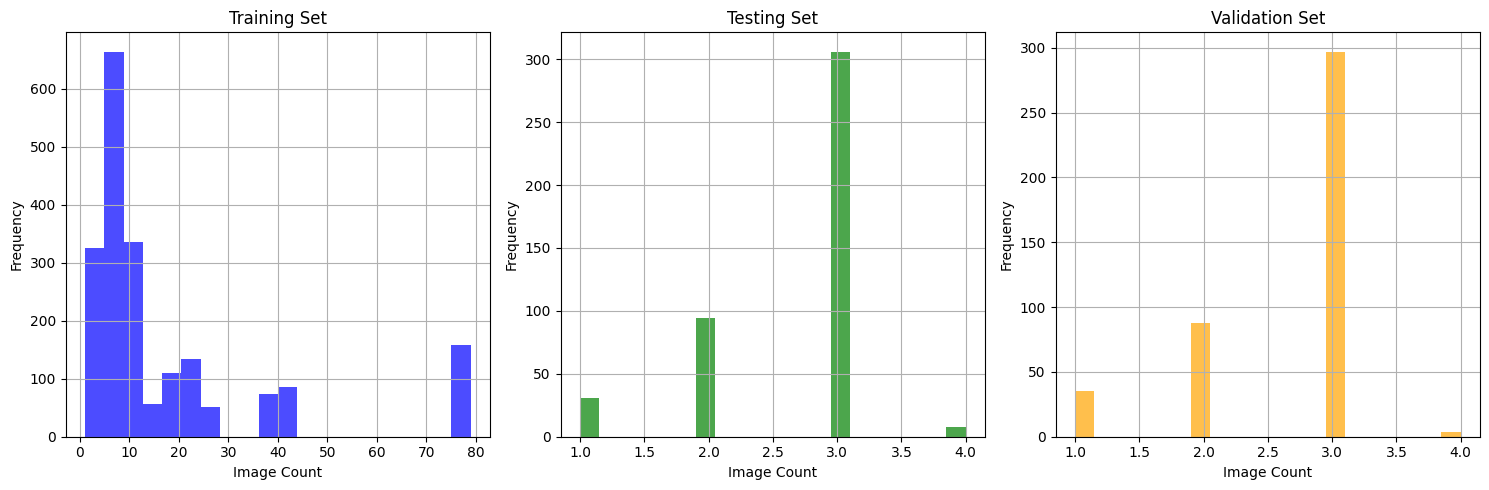

In [61]:
# Plot data

from tools import add_image_count

# Add 'image_count" column
df_tr = add_image_count(df_tr, 'name_viewpoint')
df_te = add_image_count(df_te, 'name_viewpoint')
df_val = add_image_count(df_val, 'name_viewpoint')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms for each DataFrame in a separate subplot
df_tr['image_count'].hist(ax=axes[0], bins=20, color='blue', alpha=0.7)
axes[0].set_title('Training Set')
axes[0].set_xlabel('Image Count')
axes[0].set_ylabel('Frequency')

df_te['image_count'].hist(ax=axes[1], bins=20, color='green', alpha=0.7)
axes[1].set_title('Testing Set')
axes[1].set_xlabel('Image Count')
axes[1].set_ylabel('Frequency')

df_val['image_count'].hist(ax=axes[2], bins=20, color='orange', alpha=0.7)
axes[2].set_title('Validation Set')
axes[2].set_xlabel('Image Count')
axes[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

### Generate files to be exported






In [62]:
dfa_tr, dfi_tr, dfn_tr, dfc_tr = final_join(df_tr, dfa, dfi, dfn, dfc, df)
dfa_te, dfi_te, dfn_te, dfc_te = final_join(df_te, dfa, dfi, dfn, dfc, df)
dfa_val, dfi_val, dfn_val, dfc_val = final_join(df_val, dfa, dfi, dfn, dfc, df)

### Final data distribution sanity checks

<AxesSubplot:>

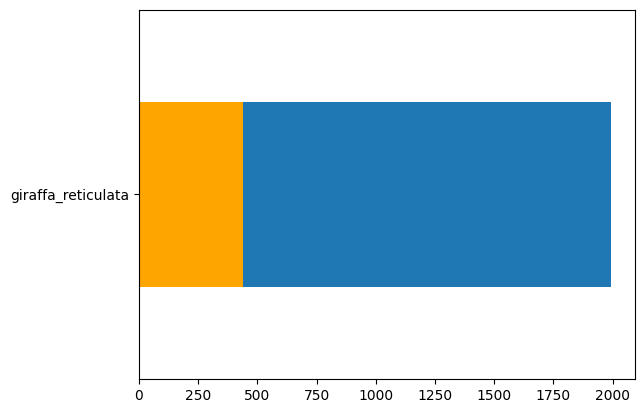

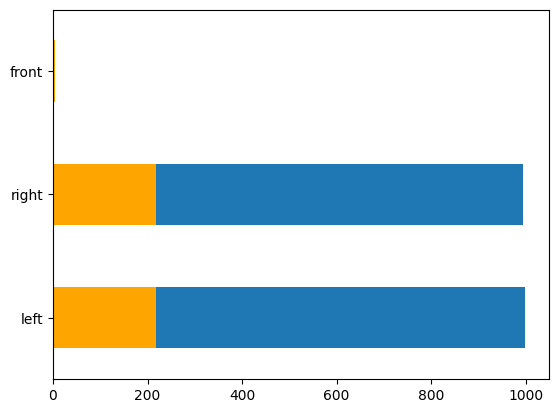

In [63]:
fig, ax = plt.subplots()
# ax2 = ax.twiny()
dfa_tr['species'].value_counts().plot(kind='barh', ax=ax)
dfa_te['species'].value_counts().plot(kind='barh', ax=ax, color='orange')

fig, ax = plt.subplots()
# ax2 = ax.twiny()
dfa_tr['viewpoint'].value_counts().plot(kind='barh', ax=ax)
dfa_te['viewpoint'].value_counts().plot(kind='barh', ax=ax, color='orange')

In [64]:
assert not dfa_tr['uuid'].duplicated().any()

### Export

In [65]:
export_dir = config["export_dir"]
os.makedirs(export_dir, exist_ok=True)


def coco_path(split): return f"instances_{split}2024.json"


train_coco_path = os.path.join(export_dir, coco_path('train'))
val_coco_path = os.path.join(export_dir, coco_path('val'))
test_coco_path = os.path.join(export_dir, coco_path('test'))

export_annos(dfa_tr, dfi_tr, dfn_tr, dfc_tr, train_coco_path)
export_annos(dfa_val, dfi_val, dfn_val, dfc_val, val_coco_path)
export_annos(dfa_te, dfi_te,  dfn_te, dfc_te,test_coco_path)

out_path: /media/kate/Elements1/ISYNC-LUT/giraffe_TAMIL/giraffe_eda1/coco/split/instances_train2024.json
shapes:  (1994, 10) (1994, 5)
len(images_list): 1994
len(annos_list): 1994
out_path: /media/kate/Elements1/ISYNC-LUT/giraffe_TAMIL/giraffe_eda1/coco/split/instances_val2024.json
shapes:  (424, 10) (424, 5)
len(images_list): 424
len(annos_list): 424
out_path: /media/kate/Elements1/ISYNC-LUT/giraffe_TAMIL/giraffe_eda1/coco/split/instances_test2024.json
shapes:  (439, 10) (439, 5)
len(images_list): 439
len(annos_list): 439
